
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [1]:
## library imports here

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, auc


In [47]:
ha_df = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha_df.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [3]:
X = ha_df.drop(columns=['cp'])
y = ha_df['cp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2 ,random_state=10, stratify=y)

In [10]:
ct = ColumnTransformer(
    [
        ('standardize', StandardScaler(), make_column_selector(dtype_include=np.number)),
        ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'), make_column_selector(dtype_include=object))
    ],
    remainder = 'passthrough'
)

In [5]:
KNN_pipeline = Pipeline(steps=[
    ('preprocessor', ct),
    ('knn', KNeighborsClassifier())
])

knn_params = {'knn__n_neighbors': range(1, 51)}
knn_gscv = GridSearchCV(KNN_pipeline, knn_params, cv=5, scoring='accuracy')
knn_gscv.fit(X_train, y_train)

y_pred = knn_gscv.best_estimator_.predict(X_test)

print(f"Best KNN parameters: {knn_gscv.best_params_}")
print(classification_report(y_test, y_pred))

accuracy_score(y_test,y_pred)
print(confusion_matrix(y_test, y_pred))

Best KNN parameters: {'knn__n_neighbors': 36}
              precision    recall  f1-score   support

           0       0.65      0.77      0.70        26
           1       0.50      0.11      0.18         9
           2       0.36      0.50      0.42        16
           3       0.00      0.00      0.00         4

    accuracy                           0.53        55
   macro avg       0.38      0.35      0.33        55
weighted avg       0.49      0.53      0.48        55

[[20  1  5  0]
 [ 1  1  7  0]
 [ 8  0  8  0]
 [ 2  0  2  0]]
Best KNN parameters: {'knn__n_neighbors': 36}
              precision    recall  f1-score   support

           0       0.65      0.77      0.70        26
           1       0.50      0.11      0.18         9
           2       0.36      0.50      0.42        16
           3       0.00      0.00      0.00         4

    accuracy                           0.53        55
   macro avg       0.38      0.35      0.33        55
weighted avg       0.49      0.5

C:\Users\rtnee\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rtnee\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rtnee\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
tree_pipeline = Pipeline([
    ("preprocessing", ct),
    ('tree', DecisionTreeClassifier(random_state=10))
])

tree_params = {
    'tree__max_depth': range(1, 5), 
    'tree__min_samples_split': range(2, 5),
    'tree__min_samples_leaf': [1, 2, 4],
                }
tree_gscv = GridSearchCV(tree_pipeline, tree_params, cv=5, scoring='accuracy')
best_tree = tree_gscv.fit(X_train, y_train)

print(f"Best Decision Tree parameters: {tree_gscv.best_params_}")
print(f"Best Accuracy Score: {tree_gscv.best_score_}")

Best Decision Tree parameters: {'tree__max_depth': 1, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}
Best Accuracy Score: 0.5919661733615221
Best Decision Tree parameters: {'tree__max_depth': 1, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}
Best Accuracy Score: 0.5919661733615221


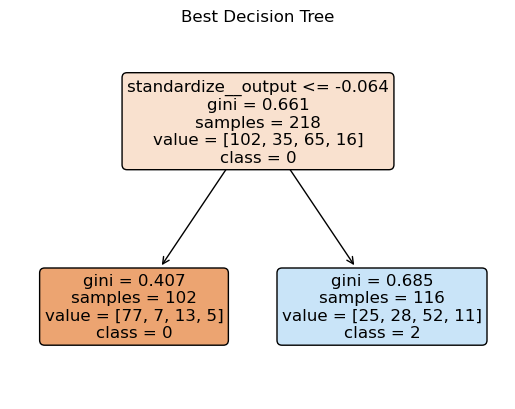

In [19]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

tree_pipeline.fit(X_train, y_train)

best_tree = tree_gscv.best_estimator_

plot_tree(best_tree.named_steps['tree'], 
          feature_names=ct.get_feature_names_out(),
          class_names=['0', '1', '2', '3'],
          filled=True,
          rounded=True,
          fontsize=12)
plt.title("Best Decision Tree")
plt.show()

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_pipeline = Pipeline([
    ("preprocessing", ct),  
    ('lda', LinearDiscriminantAnalysis())  
])

lda_params = {
    'lda__n_components': [1, 2, 3],
    'lda__tol': [1e-4, 1e-3, 1e-2]
}

lda_gscv = GridSearchCV(lda_pipeline, lda_params, cv=5, scoring='accuracy')
best_lda_model = lda_gscv.fit(X_train, y_train)

print(f"Best LDA parameters: {lda_gscv.best_params_}")
print(f"\nBest Accuracy: {lda_gscv.best_score_}")

Best LDA parameters: {'lda__n_components': 1, 'lda__tol': 0.0001}

Best Accuracy: 0.5644820295983086
Best LDA parameters: {'lda__n_components': 1, 'lda__tol': 0.0001}

Best Accuracy: 0.5644820295983086


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [48]:
ha_df["cp3"] = (ha_df["cp"] == 3).astype(int)

X = ha_df.drop(columns= ["cp", "cp3"])
y = ha_df["cp3"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y)

logistic_pipeline = Pipeline([
    ('preprocessor', ct),
    ('logit', LogisticRegression())
])

log_params = {'logit__C': [0.01, 0.1, 1, 10, 100]}
log_gscv = GridSearchCV(logistic_pipeline, log_params, cv=5, scoring='f1')
best_log_model = log_gscv.fit(X_train, y_train)

print(f"Best Logistic parameters: {log_gscv.best_params_}")
print(f"Best F1 Score (cp = 3): {log_gscv.best_score_}")

Best Logistic parameters: {'logit__C': 1}
Best F1 Score (cp = 3): 0.1
Best Logistic parameters: {'logit__C': 1}
Best F1 Score (cp = 3): 0.1


In [49]:
ha_df["cp2"] = (ha_df["cp"] == 2).astype(int)

X = ha_df.drop(columns= ["cp", "cp3", "cp2"])
y = ha_df["cp2"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

log_gscv = GridSearchCV(logistic_pipeline, log_params, cv=5, scoring='f1')
best_log_model = log_gscv.fit(X_train, y_train)

print(f"Best Logistic parameters: {log_gscv.best_params_}")
print(f"Best F1 Score (cp = 2): {log_gscv.best_score_}")

Best Logistic parameters: {'logit__C': 1}
Best F1 Score (cp = 2): 0.1743557422969188
Best Logistic parameters: {'logit__C': 1}
Best F1 Score (cp = 2): 0.1743557422969188


In [50]:
ha_df["cp1"] = (ha_df["cp"] == 1).astype(int)

X = ha_df.drop(columns= ["cp", "cp3", "cp2", "cp1"])
y = ha_df["cp1"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y)

log_gscv = GridSearchCV(logistic_pipeline, log_params, cv=5, scoring='f1')
best_log_model = log_gscv.fit(X_train, y_train)

print(f"Best Logistic parameters: {log_gscv.best_params_}")
print(f"Best F1 Score (cp = 1): {log_gscv.best_score_}")

Best Logistic parameters: {'logit__C': 100}
Best F1 Score (cp = 1): 0.1
Best Logistic parameters: {'logit__C': 100}
Best F1 Score (cp = 1): 0.1


In [52]:
ha_df["cp0"] = (ha_df["cp"] == 0).astype(int)

X = ha_df.drop(columns= ["cp", "cp0", "cp3", "cp2", "cp1"])
y = ha_df["cp0"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y)

log_gscv = GridSearchCV(logistic_pipeline, log_params, cv=5, scoring='f1')
best_log_model = log_gscv.fit(X_train, y_train)

print(f"Best Logistic parameters: {log_gscv.best_params_}")
print(f"Best F1 Score (cp = 1): {log_gscv.best_score_}")

Best Logistic parameters: {'logit__C': 0.1}
Best F1 Score (cp = 1): 0.7392995863727572
Best Logistic parameters: {'logit__C': 0.1}
Best F1 Score (cp = 1): 0.7392995863727572


Based on the above F1 scores, the best OvR model is the one for chest pain type 1. This gave a score of 0.74 while the other models have scores around 0.1.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [53]:
ha_df_01 = ha_df[(ha_df["cp"] == 0) | (ha_df["cp"] == 1)]
X = ha_df_01.drop(columns=['cp','cp0','cp1','cp2','cp3'])
y = ha_df_01['cp']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y)

In [43]:
ovo_pipeline = Pipeline([
    ('preprocessing', ct),
    ('logit', LogisticRegression(max_iter=1000))
])

logit_params = {'logit__C': [0.01, 0.1, 1, 10, 100]}
logit_gscv = GridSearchCV(ovo_pipeline, logit_params, cv=5, scoring='roc_auc')
best_logit = logit_gscv.fit(X_train, y_train)

print(f"Best Logistic parameters: {logit_gscv.best_params_}")
print(f"Best ROC AUC (0-1): {logit_gscv.best_score_}")

Best Logistic parameters: {'logit__C': 0.01}

Best ROC AUC (0-1): 0.7901378446115288
Best Logistic parameters: {'logit__C': 0.01}

Best ROC AUC (0-1): 0.7901378446115288


In [54]:
ha_df_02 = ha_df[(ha_df["cp"] == 0) | (ha_df["cp"] == 2)]
X = ha_df_02.drop(columns=['cp','cp0','cp1','cp2','cp3'])
y = ha_df_02['cp']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y)

ovo_pipeline = Pipeline([
    ('preprocessing', ct),
    ('logit', LogisticRegression(max_iter=1000))
])

logit_params = {'logit__C': [0.01, 0.1, 1, 10, 100]}
logit_gscv = GridSearchCV(ovo_pipeline, logit_params, cv=5, scoring='roc_auc')
best_logit = logit_gscv.fit(X_train, y_train)

print(f"Best Logistic parameters: {logit_gscv.best_params_}")
print(f"Best ROC AUC (0-2): {logit_gscv.best_score_}")

Best Logistic parameters: {'logit__C': 10}

Best ROC AUC (0-2): 0.7739473684210526
Best Logistic parameters: {'logit__C': 10}

Best ROC AUC (0-2): 0.7739473684210526


In [56]:
ha_df_03 = ha_df[(ha_df["cp"] == 0) | (ha_df["cp"] == 3)]
X = ha_df_03.drop(columns=['cp','cp0','cp1','cp2','cp3'])
y = ha_df_03['cp']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y)

ovo_pipeline = Pipeline([
    ('preprocessing', ct),
    ('logit', LogisticRegression(max_iter=1000))
])

logit_params = {'logit__C': [0.01, 0.1, 1, 10, 100]}
logit_gscv = GridSearchCV(ovo_pipeline, logit_params, cv=5, scoring='roc_auc')
best_logit = logit_gscv.fit(X_train, y_train)

print(f"Best Logistic parameters: {logit_gscv.best_params_}")
print(f"Best ROC AUC (0-3): {logit_gscv.best_score_}")

Best Logistic parameters: {'logit__C': 0.1}

Best ROC AUC (0-3): 0.7280701754385965
Best Logistic parameters: {'logit__C': 0.1}

Best ROC AUC (0-3): 0.7280701754385965


Based on the above AUC models the best OvO model is the one that includes only values of 0 and 1 chest pain types. The AUC is 0.79 for this model which is slightly better than the other two models that looks to compare 0 to 2 and 0 to 3.